<a href="https://colab.research.google.com/github/HiImCoder1818/AI_portfolio/blob/main/LLM_stock_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall -y sympy
!pip install sympy==1.12


Found existing installation: sympy 1.13.1
Uninstalling sympy-1.13.1:
  Successfully uninstalled sympy-1.13.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 37.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-runtime-cu12==12.4.127; platform_system 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from google.colab import drive
from torch.optim.lr_scheduler import StepLR
import pickle
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

torch.set_printoptions(sci_mode=False)

In [ ]:
stock_tickers = [
    # Technology Companies
    "AAPL",  # Apple
    "MSFT",  # Microsoft
    "GOOG",  # Alphabet (Google) Class C
    "AMZN",  # Amazon
    "NVDA",  # NVIDIA
    "TSLA",  # Tesla
    "META",  # Meta (Facebook)
    "INTC",  # Intel

    # Financial Companies
    "JPM",  # JPMorgan Chase
    "BAC",  # Bank of America
    "WFC",  # Wells Fargo
    "V",  # Visa
    "MA",  # Mastercard
    "PYPL",  # PayPal

    # Retail & Consumer Goods
    "WMT",  # Walmart
    "COST",  # Costco
    "TGT",  # Target
    "HD",  # Home Depot
    "MCD",  # McDonald's
    "SBUX",  # Starbucks

    # Automotive & Industrial
    "F",  # Ford
    "TM",  # Toyota
    "HMC",  # Honda
    "BA",  # Boeing
    "CAT",  # Caterpillar

    # Healthcare & Pharmaceuticals
    "JNJ",  # Johnson & Johnson
    "PFE",  # Pfizer

    # Energy & Utilities
    "CVX",  # Chevron
    "SHEL",  # Shell

    # Entertainment & Media
    "DIS",  # Walt Disney
    "NFLX",  # Netflix
    "WBD",  # Warner Bros. Discovery
    "SPOT",  # Spotify
]

block_size = 60
batch_size = 128
learning_rate = 0.0005
max_iters = 900
eval_iters = 250
save_iters = 50
n_embd = 256
n_layers = 10
n_head = 8
dropout = 0.15

train_from = 2000
train_to = 2020
val_from = 2021
val_to = 2024

device = 'cpu'



In [ ]:
cached_data = {}
scaler = MinMaxScaler()

In [ ]:
def download_all_stocks():
    global cached_data

    for ticker in stock_tickers:
        try:
            df_train = yf.download(ticker, start=f"{train_from}-01-01", end=f"{train_to}-01-01")
            df_val = yf.download(ticker, start=f"{val_from}-01-01", end=f"{val_to}-01-01")

            if df_train.empty or df_val.empty:
                print(f"Warning: No data for {ticker}. Skipping.")
                continue

            for df in [df_train, df_val]:
                df["SMA_10"] = df["Close"].rolling(window=10).mean()
                df["RSI"] = 100 - (100 / (1 + df["Close"].pct_change().rolling(14).mean()))
                df["MACD"] = df["Close"].ewm(span=12).mean() - df["Close"].ewm(span=26).mean()

                df.dropna(inplace=True)
                df.fillna(0, inplace=True)

            cached_data[ticker] = {
                "train": pd.DataFrame(scaler.fit_transform(df_train), columns=df_train.columns, index=df_train.index),
                "val": pd.DataFrame(scaler.fit_transform(df_val), columns=df_val.columns, index=df_val.index)
            }

            print(f"✅ {ticker} data loaded successfully!")

        except Exception as e:
            print(f"Error fetching {ticker}: {e}. Skipping.")

download_all_stocks()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


✅ AAPL data loaded successfully!


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


✅ MSFT data loaded successfully!


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


✅ GOOG data loaded successfully!


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


✅ AMZN data loaded successfully!


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


✅ NVDA data loaded successfully!


[*********************100%***********************]  1 of 1 completed


✅ TSLA data loaded successfully!


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


✅ META data loaded successfully!


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


✅ INTC data loaded successfully!


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


✅ JPM data loaded successfully!


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


✅ BAC data loaded successfully!


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


✅ WFC data loaded successfully!


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


✅ V data loaded successfully!


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


✅ MA data loaded successfully!


[*********************100%***********************]  1 of 1 completed


✅ PYPL data loaded successfully!


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


✅ WMT data loaded successfully!


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


✅ COST data loaded successfully!


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


✅ TGT data loaded successfully!


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


✅ HD data loaded successfully!


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


✅ MCD data loaded successfully!


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


✅ SBUX data loaded successfully!


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


✅ F data loaded successfully!


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


✅ TM data loaded successfully!


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


✅ HMC data loaded successfully!


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


✅ BA data loaded successfully!


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


✅ CAT data loaded successfully!


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


✅ JNJ data loaded successfully!


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


✅ PFE data loaded successfully!


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


✅ CVX data loaded successfully!


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


✅ SHEL data loaded successfully!


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

✅ DIS data loaded successfully!



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

✅ NFLX data loaded successfully!



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


✅ WBD data loaded successfully!


[*********************100%***********************]  1 of 1 completed

✅ SPOT data loaded successfully!


In [ ]:
def decode(scaled_tensor):
    device = scaled_tensor.device

    scaled_tensor = scaled_tensor.cpu().numpy()

    num_features = scaled_tensor.shape[-1]
    feature_min = scaler.data_min_[:num_features]
    feature_max = scaler.data_max_[:num_features]

    real_values = scaled_tensor * (feature_max - feature_min) + feature_min

    return torch.tensor(real_values, dtype=torch.float32).to(device)

print(decode(torch.tensor([0.4958, 0.4937, 0.4966, 0.4949, 0.4704, 0.5882], dtype=torch.float32)))


tensor([  216.5871,   227.8998,   210.7629,   214.9462, 7127181.5000,   234.5499])


In [ ]:
cached_data['SPOT']["train"]["SMA_10"]
cached_data


{'AAPL': {'train': Price          Close      High       Low      Open    Volume    SMA_10  \
  Ticker          AAPL      AAPL      AAPL      AAPL      AAPL             
  Date                                                                     
  2000-01-24  0.008491  0.009156  0.008576  0.008826  0.054392  0.008186   
  2000-01-25  0.009127  0.009195  0.008280  0.008458  0.062014  0.008345   
  2000-01-26  0.008908  0.009308  0.009074  0.008993  0.044406  0.008535   
  2000-01-27  0.008888  0.009182  0.008778  0.008866  0.040747  0.008784   
  2000-01-28  0.008000  0.008957  0.008092  0.008799  0.052017  0.008838   
  ...              ...       ...       ...       ...       ...       ...   
  2019-12-24  0.967968  0.969026  0.977141  0.977852  0.001238  0.976220   
  2019-12-26  0.987229  0.986390  0.983307  0.978300  0.007285  0.982949   
  2019-12-27  0.986852  1.000000  0.995151  1.000000  0.014484  0.989397   
  2019-12-30  0.992726  0.995634  0.985107  0.994282  0.014193  0.99515

In [ ]:
def get_batch(split):
  ticker = stock_tickers[torch.randint(0, len(stock_tickers), (1,))]

  df = cached_data[ticker][split].copy()

  trading_days = df.index.strftime("%Y-%m-%d").tolist()
  features = ["Open", "High", "Low", "Close", "Volume", "SMA_10", "RSI", "MACD"]

  x_batches = []
  y_batches = []

  for _ in range(batch_size):
      start_index = torch.randint(0, len(trading_days)-block_size-1, (1,))
      start_date = trading_days[start_index]

      x_sequence = df.loc[trading_days[start_index : start_index+block_size], features].values
      x_batches.append(x_sequence)

      y_sequence = df.loc[trading_days[start_index + 1 : start_index+block_size+1], ["Low", "High", "Close"]].values
      y_batches.append(y_sequence)

  x = torch.tensor(x_batches, dtype=torch.float32).to(device)
  y = torch.tensor(y_batches, dtype=torch.float32).to(device)

  return df, ticker, x, decode(y)

df, tick, x, y = get_batch('train')

print(tick)

print("inputs: ")
print(x)
print("targets")
print(y)

GOOG
inputs: 
tensor([[[0.8062, 0.8085, 0.7975,  ..., 0.8350, 0.3771, 0.1718],
         [0.8029, 0.8167, 0.8079,  ..., 0.8289, 0.4196, 0.1850],
         [0.8195, 0.8204, 0.8077,  ..., 0.8222, 0.3957, 0.1926],
         ...,
         [0.7812, 0.7865, 0.7757,  ..., 0.7605, 0.5737, 0.5389],
         [0.7854, 0.7851, 0.7802,  ..., 0.7681, 0.5550, 0.5711],
         [0.7748, 0.7763, 0.7735,  ..., 0.7704, 0.5571, 0.5906]],

        [[0.1668, 0.1687, 0.1661,  ..., 0.1783, 0.3293, 0.4305],
         [0.1681, 0.1684, 0.1643,  ..., 0.1763, 0.3419, 0.4177],
         [0.1658, 0.1662, 0.1624,  ..., 0.1740, 0.3114, 0.4063],
         ...,
         [0.1717, 0.1732, 0.1721,  ..., 0.1788, 0.4637, 0.5349],
         [0.1726, 0.1735, 0.1726,  ..., 0.1785, 0.4608, 0.5270],
         [0.1709, 0.1705, 0.1692,  ..., 0.1777, 0.4383, 0.5165]],

        [[0.4381, 0.4374, 0.4370,  ..., 0.4321, 0.5720, 0.5081],
         [0.4388, 0.4472, 0.4403,  ..., 0.4334, 0.6161, 0.5285],
         [0.4455, 0.4466, 0.4469,  ..., 0.43

In [ ]:
# TODO: RoPE, proccess features with lstm, sentiment analysis,
# FEATURE: lstm proccessed SMA's, sentiment analysis betwee 0 and 1

class Head(nn.Module):
  def __init__(self, head_size):
    super().__init__()
    self.key = nn.Linear(n_embd, head_size, bias=False)
    self.query = nn.Linear(n_embd, head_size, bias=False)
    self.value = nn.Linear(n_embd, head_size, bias=False)

    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
      B, T, C = x.shape

      k = self.key(x)
      q = self.query(x)
      v = self.value(x)

      wei = q @ k.transpose(-2, -1) * (k.shape[-1] ** -0.5)
      wei = F.softmax(wei, dim=-1)
      wei = self.dropout(wei)

      out = wei @ v
      return out

class MultiHeadAttention(nn.Module):
  def __init__(self, n_head, head_size):
    super().__init__()

    self.heads = nn.ModuleList([Head(head_size) for _ in range(n_head)])
    self.proj = nn.Linear(head_size*n_head, n_embd)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    out = torch.cat([h(x) for h in self.heads], dim=-1)
    out = self.dropout(self.proj(out))

    return out

class FeedForward(nn.Module):
  def __init__(self, n_embd):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(n_embd, 4*n_embd),
        nn.GELU(),
        nn.Linear(4*n_embd, n_embd),
        nn.Dropout(dropout)

    )

  def forward(self, x):
    return self.net(x)

class Block(nn.Module):
  def __init__(self, n_embd, n_head):
    super().__init__()

    head_size = n_embd//n_head
    self.self_attention = MultiHeadAttention(n_head, head_size)

    self.ffwd = FeedForward(n_embd)
    self.ln1 = nn.LayerNorm(n_embd)
    self.ln2 = nn.LayerNorm(n_embd)

  def forward(self, x):
    x = x + self.self_attention(self.ln1(x));
    x = x + self.ffwd(self.ln2(x));

    return x

class StockTransformer(nn.Module):
  def __init__(self):
    super().__init__()

    self.input_projection = nn.Linear(8, n_embd)
    self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layers)])
    self.lm_f = nn.LayerNorm(n_embd)
    self.lm_head = nn.Sequential(
        nn.Linear(n_embd, 3),
        nn.ReLU()
    )

  def forward(self, x, targets=None):
    x = self.input_projection(x)
    x = self.blocks(x)
    x = self.lm_f(x)
    logits = self.lm_head(x)

    if targets is None:
        return logits

    loss = F.smooth_l1_loss(logits, targets)

    return logits, loss

  def generate(self, x, future_days):
    for _ in range(future_days):
        with torch.no_grad():
            x = x[:, -block_size:, :]

            logits = self.forward(x)

        next_day = logits[:, -1, :].unsqueeze(1)

        padding = torch.zeros(next_day.shape[0], next_day.shape[1], 5).to(device)
        next_day_padded = torch.cat((next_day, padding), dim=2)

        x = torch.cat((x, next_day_padded), dim=1)

    return x[:, -future_days:, :3]


In [ ]:
model = StockTransformer()
m = model.to(device)

In [ ]:
@torch.no_grad()
def estimate_loss():
  out = {}
  m.eval()

  for split in ["train", "val"]:
    losses = torch.zeros(eval_iters)

    for k in range(eval_iters):
      df, tick, X, Y = get_batch(split)

      logits, loss = m(X, Y)
      losses[k] = loss.item()

    out[split] = losses.mean()

  m.train()

  return out


In [ ]:
import io

class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)


In [ ]:
with open("stock-model-epoch-1500.pkl", 'rb') as f:
    model = CPU_Unpickler(f).load()
m = model.to(device)

In [ ]:
drive.mount('/content/drive')
optimizer = torch.optim.AdamW(m.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=500, gamma=0.3)

for epoch in range(max_iters):
    if epoch % save_iters == 0:
      with open(f"/content/drive/MyDrive/stock-model-epoch-{epoch}-cpu.pkl", 'wb') as f:
        pickle.dump(m, f)

    if epoch % eval_iters == 0:
        losses = estimate_loss()
        print(f"Epochs: {epoch}, Train Loss: {losses['train']:.4f}, Val Loss: {losses['val']:.4f}")

    xb, yb = get_batch("train")

    logits, loss = m.forward(xb, yb)

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()

print(loss.item())

m.cpu()

with open("/content/drive/MyDrive/stock-model.pkl", 'wb') as f:
    pickle.dump(m, f)
print('model saved')

Mounted at /content/drive
Epochs: 0, Train Loss: 2.4973, Val Loss: 2.6081
Epochs: 250, Train Loss: 2.4821, Val Loss: 2.5583
Epochs: 500, Train Loss: 2.5463, Val Loss: 2.4421
Epochs: 750, Train Loss: 2.0623, Val Loss: 2.1551
1.9035074710845947
model saved


In [ ]:
# with open("stock-model.pkl", 'rb') as f:
#     model = CPU_Unpickler(f).load()
# m = model.to(device)

with open("stock-model.pkl", 'rb') as f:
    model = pickle.load(f)
m = model.to(device)

df, tick, x, y = get_batch('val')

predictions = m.generate(x[0].unsqueeze(0), 3).squeeze(0)

print(predictions)
print(y)

tensor([[343.1776, 364.8084, 334.0395],
        [334.9524, 355.7472, 326.1252],
        [335.0130, 355.4402, 326.4048]])
tensor([[[337.1421, 356.4462, 327.6633],
         [339.8621, 360.5876, 327.1841],
         [336.9987, 358.9400, 325.2674],
         ...,
         [328.3176, 347.8552, 317.1336],
         [332.3134, 353.4781, 324.1522],
         [334.5198, 355.4123, 322.0547]],

        [[190.2379, 214.7271, 183.8375],
         [185.7192, 201.7634, 186.7814],
         [189.2250, 199.4064, 185.8756],
         ...,
         [266.4212, 282.2859, 260.9456],
         [273.8965, 289.5879, 264.4479],
         [276.1650, 298.8851, 275.3354]],

        [[109.0320, 108.8495, 103.7136],
         [107.6822, 108.7663, 102.5185],
         [111.4220, 114.1809, 107.8221],
         ...,
         [138.6632, 144.5211, 132.8850],
         [136.0922, 141.9957, 132.2812],
         [141.4678, 147.4675, 139.4523]],

        ...,

        [[282.7106, 304.9628, 281.2675],
         [292.8083, 312.4258, 285.7289

In [ ]:
companies = {
    # Technology Companies
    "AAPL": "Apple",
    "MSFT": "Microsoft",
    "GOOG": "Alphabet (Google) Class C",
    "AMZN": "Amazon",
    "NVDA": "NVIDIA",
    "TSLA": "Tesla",
    "META": "Meta (Facebook)",
    "INTC": "Intel",

    # Financial Companies
    "JPM": "JPMorgan Chase",
    "BAC": "Bank of America",
    "WFC": "Wells Fargo",
    "V": "Visa",
    "MA": "Mastercard",
    "PYPL": "PayPal",

    # Retail & Consumer Goods
    "WMT": "Walmart",
    "COST": "Costco",
    "TGT": "Target",
    "HD": "Home Depot",
    "MCD": "McDonald's",
    "SBUX": "Starbucks",

    # Automotive & Industrial
    "F": "Ford",
    "TM": "Toyota",
    "HMC": "Honda",
    "BA": "Boeing",
    "CAT": "Caterpillar",

    # Healthcare & Pharmaceuticals
    "JNJ": "Johnson & Johnson",
    "PFE": "Pfizer",

    # Energy & Utilities
    "CVX": "Chevron",
    "SHEL": "Shell",

    # Entertainment & Media
    "DIS": "Walt Disney",
    "NFLX": "Netflix",
    "WBD": "Warner Bros. Discovery",
    "SPOT": "Spotify",
}


[[205.0011  216.35626 199.2054 ]
 [308.89777 327.5471  301.43253]
 [304.57428 322.5375  297.09122]
 [305.388   323.11606 297.7931 ]
 [306.10522 324.1984  298.68994]
 [305.28442 323.2416  298.12897]
 [304.2172  322.1476  296.88   ]
 [304.6811  322.64166 297.2356 ]
 [304.89737 322.64417 297.5885 ]
 [304.99188 322.9217  297.82233]
 [305.80878 323.6687  298.4541 ]
 [305.3779  323.1118  297.83273]
 [304.9043  322.68802 297.50217]
 [305.2366  323.02036 297.87335]
 [305.2151  322.9418  297.72992]
 [304.7718  322.46994 297.2223 ]
 [304.47284 321.87634 296.65387]
 [305.66714 323.59717 298.25983]
 [306.3545  324.5699  298.4687 ]
 [304.141   321.86325 296.71527]]


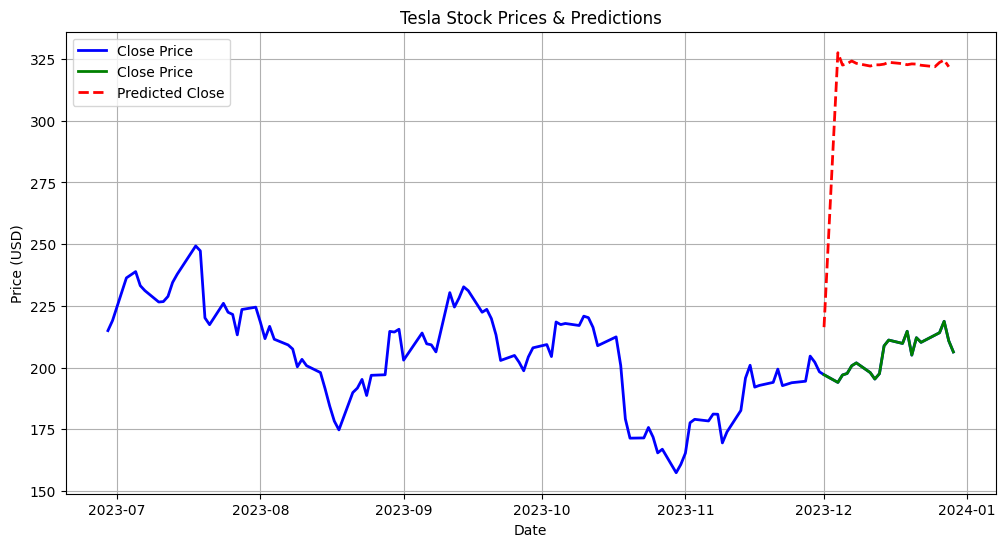

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

future_days = 20

df, tick, x, y = get_batch('val')
company = companies[tick]

df = df.copy()

with open("stock-model-epoch-1250.pkl", 'rb') as f:
    model = CPU_Unpickler(f).load()
m = model.to(device)

predictions = m.generate(x[0].unsqueeze(0), future_days).squeeze(0).detach().cpu().numpy()

print(predictions)

last_date = df.index[-future_days]
future_dates = pd.date_range(start=last_date, periods=future_days, freq='B')
pred_df = pd.DataFrame(predictions, columns=["Low", "High", "Close"], index=future_dates)

close_min, close_max = scaler.data_min_[3], scaler.data_max_[3]

df["Close"] = df["Close"] * (close_max - close_min) + close_min

plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(x):], df["Close"][-len(x):], label="Close Price", color="blue", linewidth=2)
plt.plot(df.index[-future_days:], df["Close"][-future_days:], label="Close Price", color="green", linewidth=2)
plt.plot(pred_df.index, pred_df["High"], label="Predicted Close", color="red", linestyle="dashed", linewidth=2)

plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title(f"{company} Stock Prices & Predictions")
plt.legend()
plt.grid(True)

plt.show()

Final Thoughts
===================================

I was able to learn about Large Language Model's well and I was able to successfuly train my model. The reason why it failed was because of multiple reasons involving how I procceseed my features, the issue of overfitting, loss function, etc. First if I had more GPU usage, it would save lots of time as training wouldn't take 11 hours like it did with my cpu. The model kept overfitting to around 300 aka the moderm stock value. In addtion, my features were comprised of SMA_10, RSI, and MACD. Maybe if I used some other combination of features or removed some values from the feature, the model would be able to regonize more patterns easier. Also I trained on a very large dataset, with lots of stocks and companies which creates lots of randombility. If I had focused on 1 or 2 stocks, the model would be able to regonize patterns easier and learn better. Data augmentation is also a possibility but I dont know how to do that with stocks. Overall, I would probably get better feature proccessing, better training function, and focus on just 1 or 2 stocks.

ryan.boldi123@gmail.com